
# **Running Pyspark in Colab**

To run spark in Colab, You need proper setup. Next cell will create required setup for running Spark/PySpark:

In [58]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [59]:
import findspark
import io
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [60]:
data_path = "BostonHousing.csv"

# Read the CSV file into a DataFrame
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(data_path)

# Show the first few rows of the DataFrame
df.show()

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

In [61]:
from pyspark.sql.functions import col, sum

# Check for missing values
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()


+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



In [62]:
from pyspark.sql.functions import min, max, avg

# Calculate the minimum, maximum, and average of the "RM" column
df.select(min("RM"), max("RM"), avg("RM")).show()


+-------+-------+-----------------+
|min(RM)|max(RM)|          avg(RM)|
+-------+-------+-----------------+
|  3.561|   8.78|6.284634387351787|
+-------+-------+-----------------+



In [63]:
# Convert all column names to lower case
df = df.toDF(*[c.lower() for c in df.columns])

# Define the bin ranges
splits = [float('-inf'), 4.0, 5.0, 6.0, 7.0, float('inf')]

# Initialize a Bucketizer
bucketizer = Bucketizer(splits=splits, inputCol="rm", outputCol="rm_bin")

# Transform the DataFrame
df_binned = bucketizer.transform(df)

# Show the first few rows of the binned DataFrame
df_binned.show()


+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+------+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|rm_bin|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+------+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|   3.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|   3.0|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|   4.0|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|   3.0|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|   4.0|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|   3.0|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|   3.0|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|2

In [64]:
from pyspark.sql.functions import avg, min, max

# Group by the "RM_bin" column and calculate statistics
df_binned.groupBy("RM_bin").agg(avg("MEDV").alias("avg_MEDV"), min("MEDV").alias("min_MEDV"), max("MEDV").alias("max_MEDV")).show()

+------+------------------+--------+--------+
|RM_bin|          avg_MEDV|min_MEDV|max_MEDV|
+------+------------------+--------+--------+
|   0.0|              25.3|    23.1|    27.5|
|   1.0|16.023076923076925|     7.0|    50.0|
|   4.0|         38.396875|    15.0|    50.0|
|   3.0| 22.01598513011151|     7.2|    50.0|
|   2.0|17.487341772151893|     5.0|    50.0|
+------+------------------+--------+--------+



Bin 0.0 (RM range: -inf-4.0): Average MEDV = 25.3
Bin 1.0 (RM range: 4.0-5.0): Average MEDV = 16.023076923076925
Bin 2.0 (RM range: 5.0-6.0): Average MEDV = 17.487341772151893
Bin 3.0 (RM range: 6.0-7.0): Average MEDV = 22.01598513011151
Bin 4.0 (RM range: 7.0-inf): Average MEDV = 38.396875


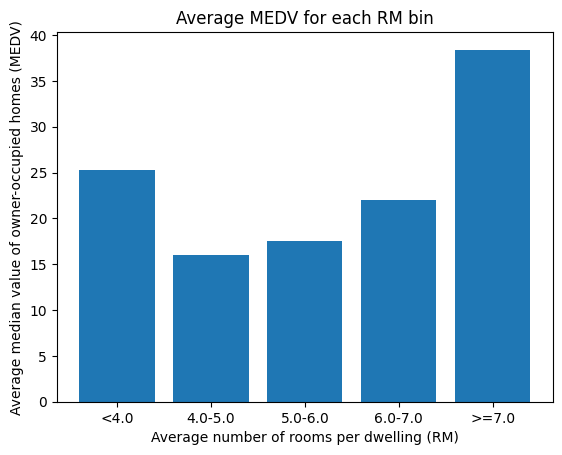

In [72]:
import matplotlib.pyplot as plt

# Collect the data to the driver node, sorted by the "RM_bin" column
binned_data = df_binned.groupBy("RM_bin").agg(avg("MEDV").alias("avg_MEDV")).sort("RM_bin").collect()

# Extract the bin labels and average MEDV values
bins = [row["RM_bin"] for row in binned_data]
avg_MEDV = [row["avg_MEDV"] for row in binned_data]

# Print the average MEDV for each bin
for i in range(len(bins)):
    print(f"Bin {bins[i]} (RM range: {splits[int(bins[i])]}-{splits[int(bins[i])+1]}): Average MEDV = {avg_MEDV[i]}")

# Create a bar plot
plt.bar(bins, avg_MEDV, tick_label=["<4.0", "4.0-5.0", "5.0-6.0", "6.0-7.0", ">=7.0"])
plt.xlabel('Average number of rooms per dwelling (RM)')
plt.ylabel('Average median value of owner-occupied homes (MEDV)')
plt.title('Average MEDV for each RM bin')
plt.show()



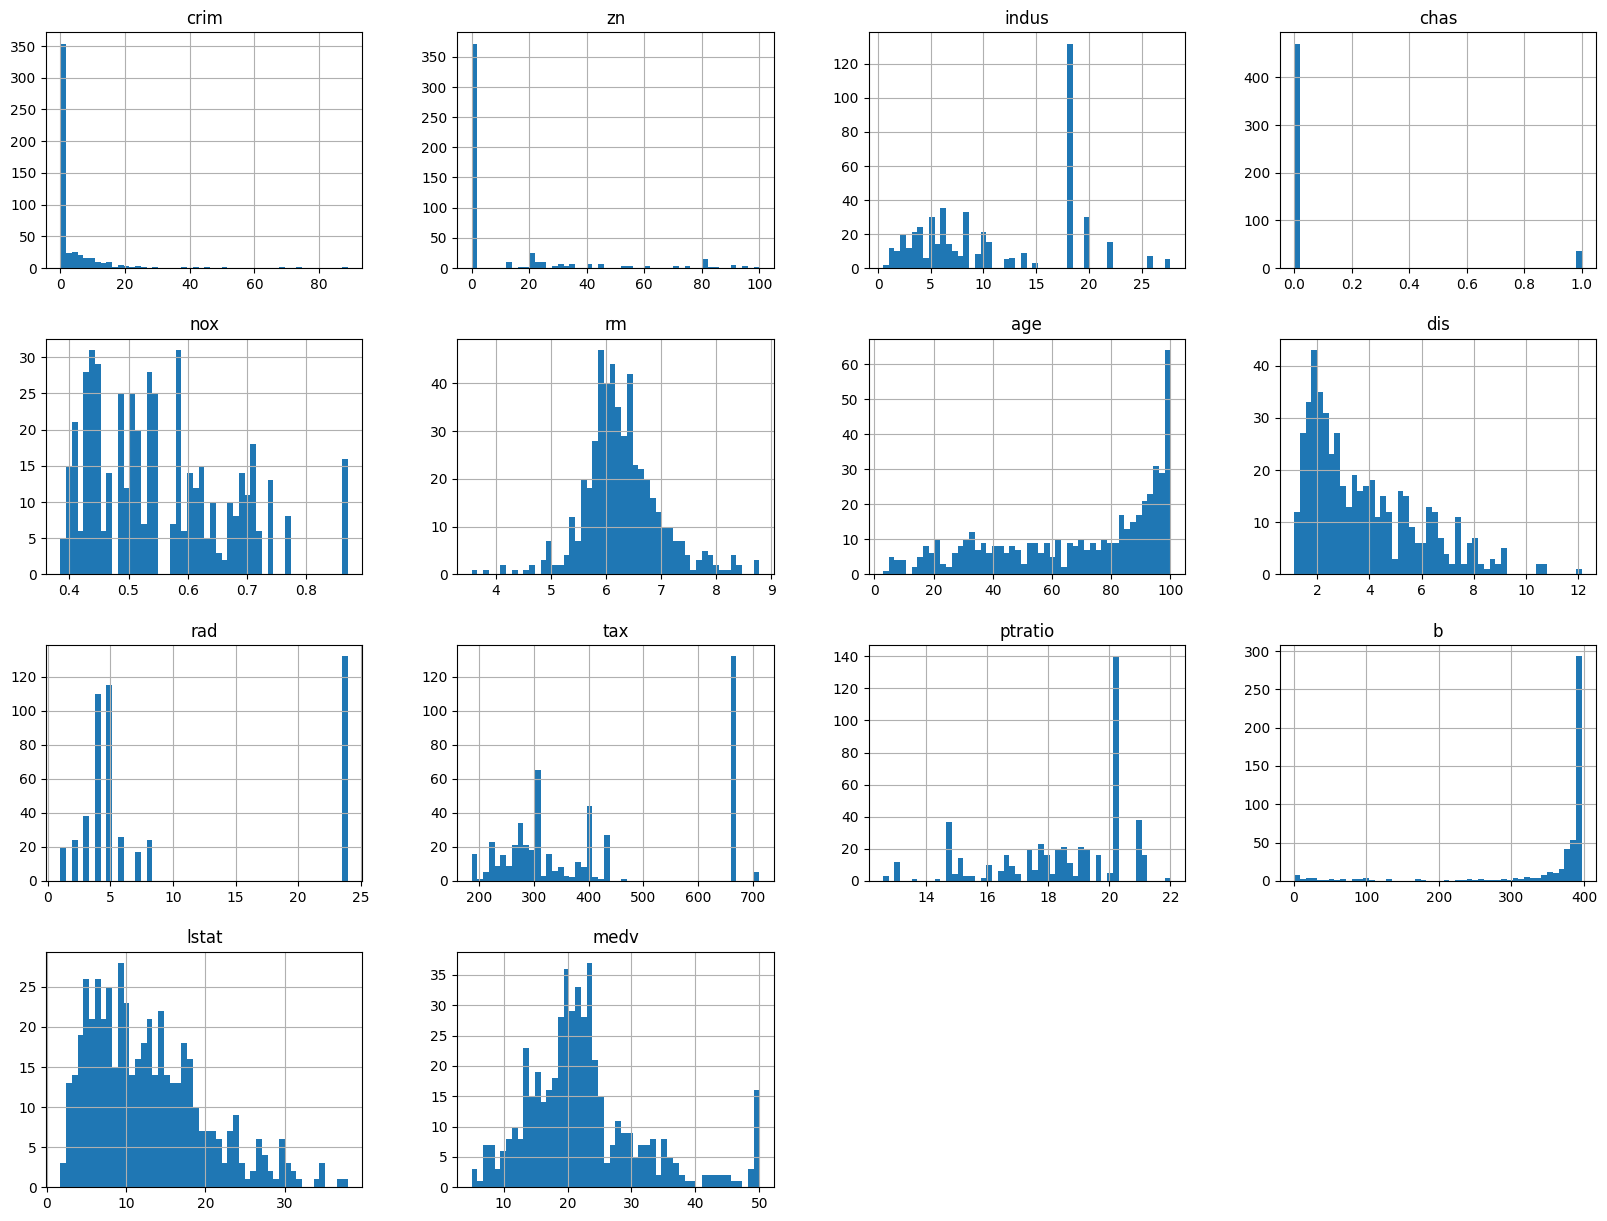

In [66]:
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas
df_pd = df.toPandas()

# Plot a histogram for each column
df_pd.hist(bins=50, figsize=(20,15))
plt.show()


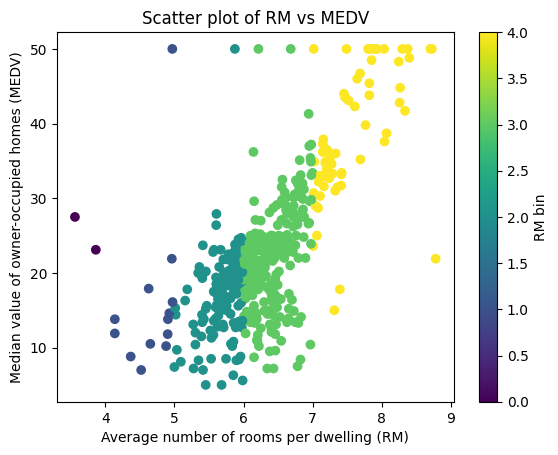

In [67]:
# Convert the binned DataFrame to Pandas
df_binned_pd = df_binned.toPandas()

# Create a scatter plot
plt.scatter(df_binned_pd['rm'], df_binned_pd['medv'], c=df_binned_pd['rm_bin'], cmap='viridis')
plt.xlabel('Average number of rooms per dwelling (RM)')
plt.ylabel('Median value of owner-occupied homes (MEDV)')
plt.title('Scatter plot of RM vs MEDV')
plt.colorbar(label='RM bin')
plt.show()


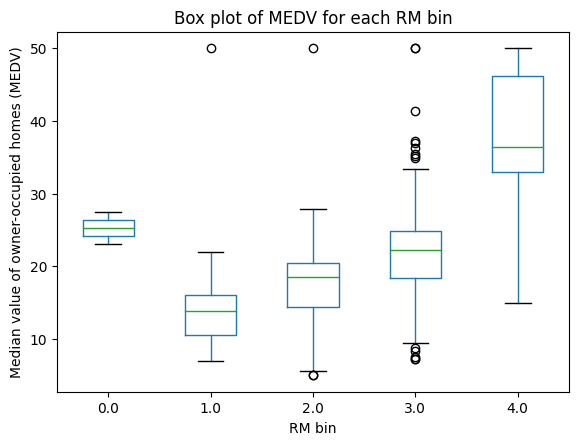

In [68]:
# Create a box plot
df_binned_pd.boxplot(column='medv', by='rm_bin', grid=False)
plt.xlabel('RM bin')
plt.ylabel('Median value of owner-occupied homes (MEDV)')
plt.title('Box plot of MEDV for each RM bin')
plt.suptitle('')  # Suppress the automatic title
plt.show()


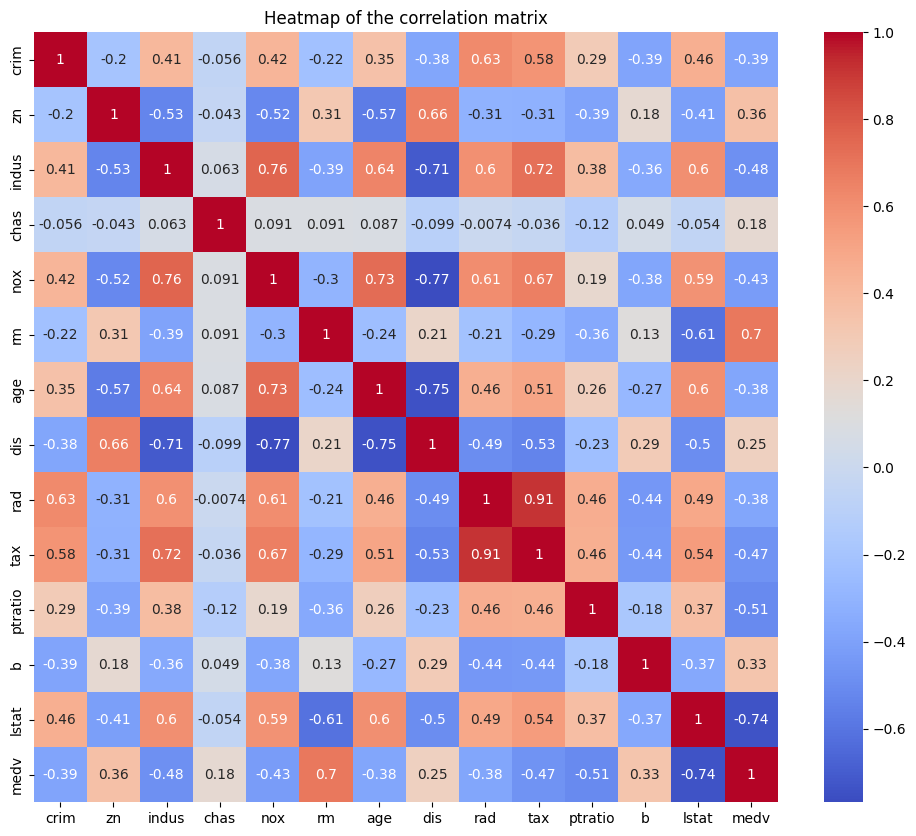

In [69]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = df_pd.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of the correlation matrix')
plt.show()


In [70]:
spark.stop()